In [1]:
import pandas as pd
import numpy as np
from sklearn import datasets
import matplotlib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, make_scorer
from IPython.display import display

In [2]:
digits_dataset = datasets.load_digits(as_frame=True)
print(digits_dataset['DESCR'])


.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 1797
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
https://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping blocks of
4x4 and the number of on pixels are counted in each blo

In [3]:
digits_data = digits_dataset['data'].values
digits_img = digits_dataset['images']
digits_target = digits_dataset['target'].values

random_state = 351871206
test_p = 0.8
val_p = 0.2

X_trainval, X_test, y_trainval, y_test = train_test_split(digits_data, digits_target, test_size=test_p, random_state=random_state, shuffle=True)

display(pd.DataFrame({'X_trainval': X_trainval.shape, 'X_test': X_test.shape}, index=['N. sanmples', 'N.features']))

,X_trainval,X_test
N. sanmples,359,1438
N.features,64,64


In [4]:
pca = PCA(0.90)
pca.fit(digits_data)

display(pd.DataFrame({'Numero PC': pca.n_components_, '% Varianza Tot. Spiegata': pca.explained_variance_ratio_.sum()}, index=['X_trainval']))

# Trasformazione dati. Salvare i vecchi in "copie di backup"

X_trainval_old = X_trainval.copy()
X_trainval = pca.transform(X_trainval)

X_test_old = X_test.copy()
X_test = pca.transform(X_test)

,Numero PC,% Varianza Tot. Spiegata
X_trainval,21,0.903199


In [5]:
# Inizializzazione iper-parametri MLP
hidden_layer_sizes = 10
activation = 'relu'
patience = 200
max_epochs = 500
verbose = False
batch_sz = 10

# Inizializzazione MLP
mlp = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=activation, batch_size=batch_sz, max_iter=max_epochs, early_stopping=True, n_iter_no_change=patience, random_state=random_state ,validation_fraction=val_p)

mlp.fit(X_trainval, y_trainval)

MLPClassifier(batch_size=10, early_stopping=True, hidden_layer_sizes=10,
              max_iter=500, n_iter_no_change=200, random_state=351871206,
              validation_fraction=0.2)

In [6]:
y_pred_trainval = mlp.predict(X_trainval)
y_pred = mlp.predict(X_test)

acc_trainval = mlp.score(X_trainval, y_trainval)
prec_trainval = precision_score(y_trainval, y_pred_trainval, average='weighted')
rec_trainval = recall_score(y_trainval, y_pred_trainval, average='weighted')
f1_trainval = f1_score(y_trainval, y_pred_trainval, average='weighted')

acc = mlp.score(X_test, y_test)
prec = precision_score(y_test, y_pred, average='weighted')
rec = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

df_perf = pd.DataFrame({'Accuracy': [acc_trainval, acc], 
                        'Precision': [prec_trainval, prec], 
                        'Recall': [rec_trainval, rec],
                        'F1': [f1_trainval, f1]}, index=['train. + val.', 'test'])

display(df_perf)

,Accuracy,Precision,Recall,F1
train. + val.,0.974930,0.975411,0.974930,0.974955
test,0.879694,0.882843,0.879694,0.880404


/Users/edovay/Documents/code/Python/MIA/.MIA/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


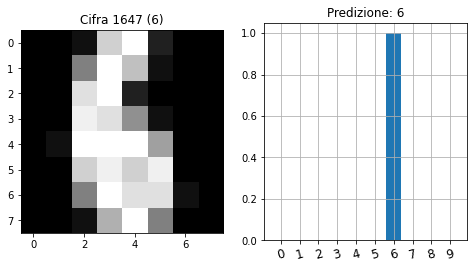

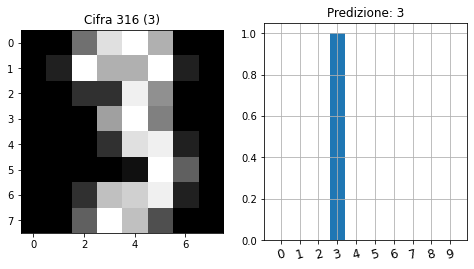

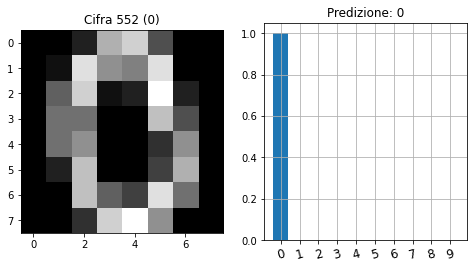

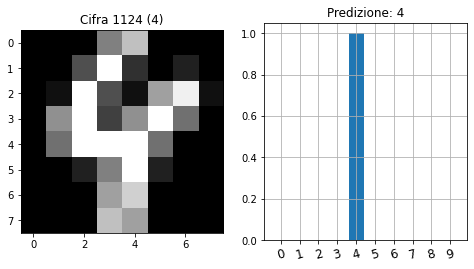

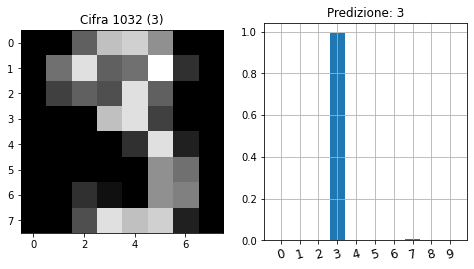

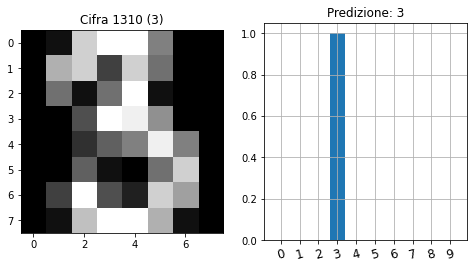

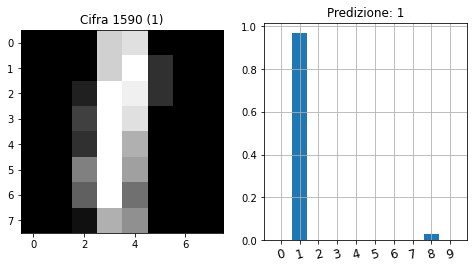

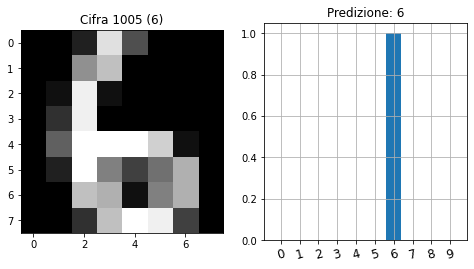

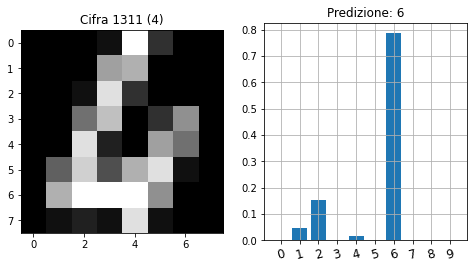

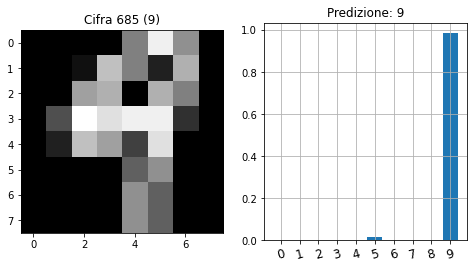

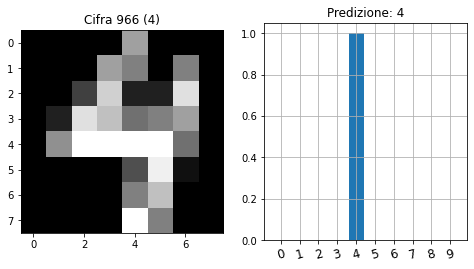

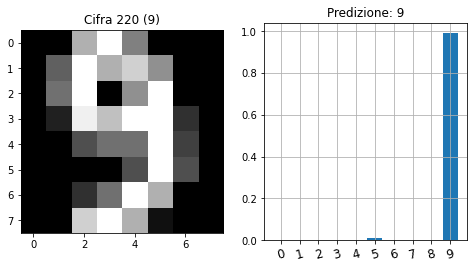

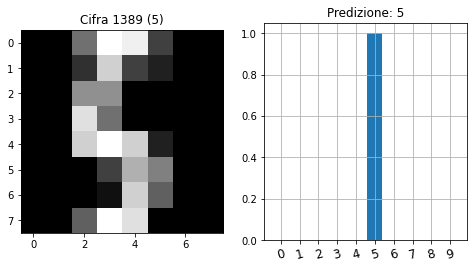

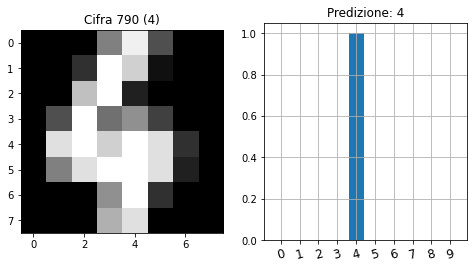

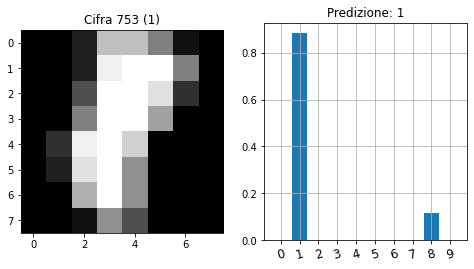

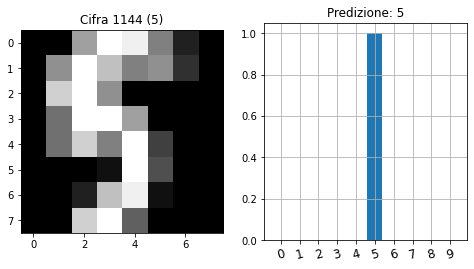

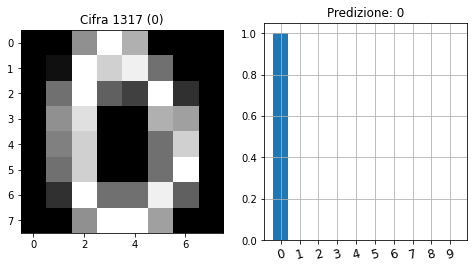

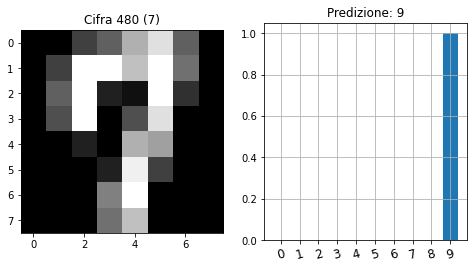

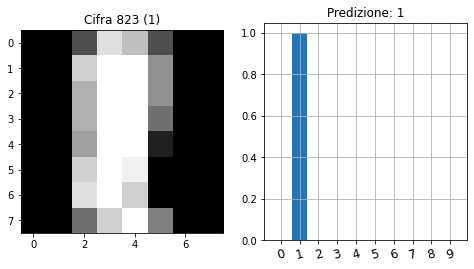

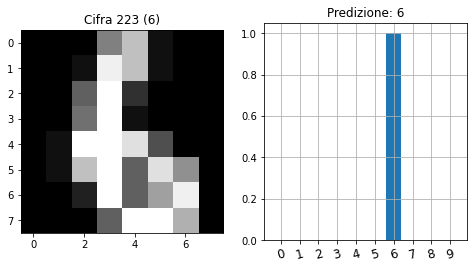

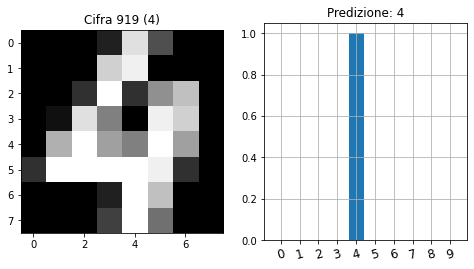

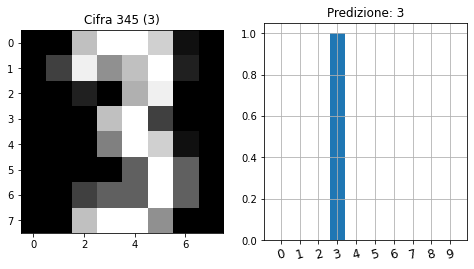

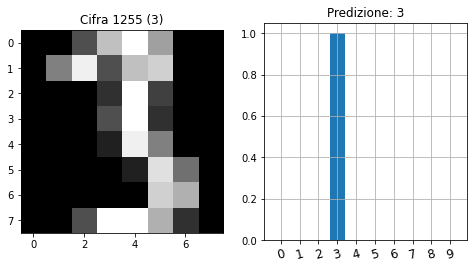

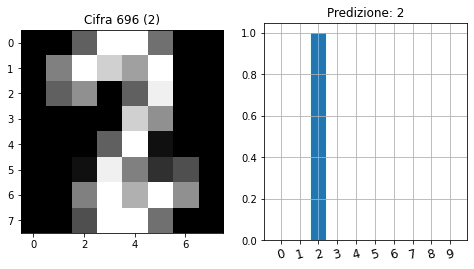

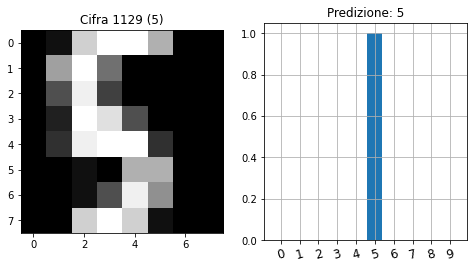

In [7]:
# Selezione di "n_randsamples" volti random dal dataset

n_randsamples = 25
ind_rand = np.random.choice(len(digits_data), n_randsamples, replace=False)

rand_digit = digits_data[ind_rand, :]
rand_target = digits_target[ind_rand]
rand_img = digits_img[ind_rand]


# Decision Function per i volti random:
digit_prob = mlp.predict_proba(pca.transform(rand_digit))
y_pred_digit = mlp.predict(pca.transform(rand_digit))

j = 0
for i in ind_rand:    
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(digits_img[i], cmap=plt.cm.gray)
    axs[0].set_title('Cifra {} ({})'.format(i, digits_target[i]))

    axs[1].set_title('Predizione: {}'.format(y_pred_digit[j]))

    axs[1].bar(np.arange(10),
               digit_prob[j, :])
    axs[1].grid()
    axs[1].set_xticks(np.arange(10))
    axs[1].set_xticklabels(np.arange(10),
                           rotation=15,
                           fontsize=12)
    #display(digit_prob[j, :])
    j+=1

plt.show()
